In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
from scipy.signal import find_peaks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import mae
from tensorflow.keras import layers
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout,MaxPooling1D,Input,LSTM
from tensorflow.keras.optimizers import Adam 
from keras.utils import to_categorical

In [2]:
mit_test_data = pd.read_csv('mitbih_test.csv', header=None)
mit_train_data = pd.read_csv('mitbih_train.csv', header=None)

X_train = mit_train_data.iloc[:, :-1].values
y_train = mit_train_data.iloc[:, -1].values
X_test = mit_test_data.iloc[:, :-1].values
y_test = mit_test_data.iloc[:, -1].values

normal = pd.read_csv('ptbdb_normal.csv', header=None)
abnormal = pd.read_csv('ptbdb_abnormal.csv', header=None)
X_normal = normal.iloc[:, :-1].values
y_normal = np.zeros(X_normal.shape[0])
X_abnormal = abnormal.iloc[:, :-1].values
y_abnormal = np.ones(X_abnormal.shape[0])

X = np.concatenate([X_normal, X_abnormal], axis=0)
y = np.concatenate([y_normal, y_abnormal], axis=0)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X = X.reshape((X.shape[0], X.shape[1], 1))

Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

Preprocessing Results for a Sample from Training Data:


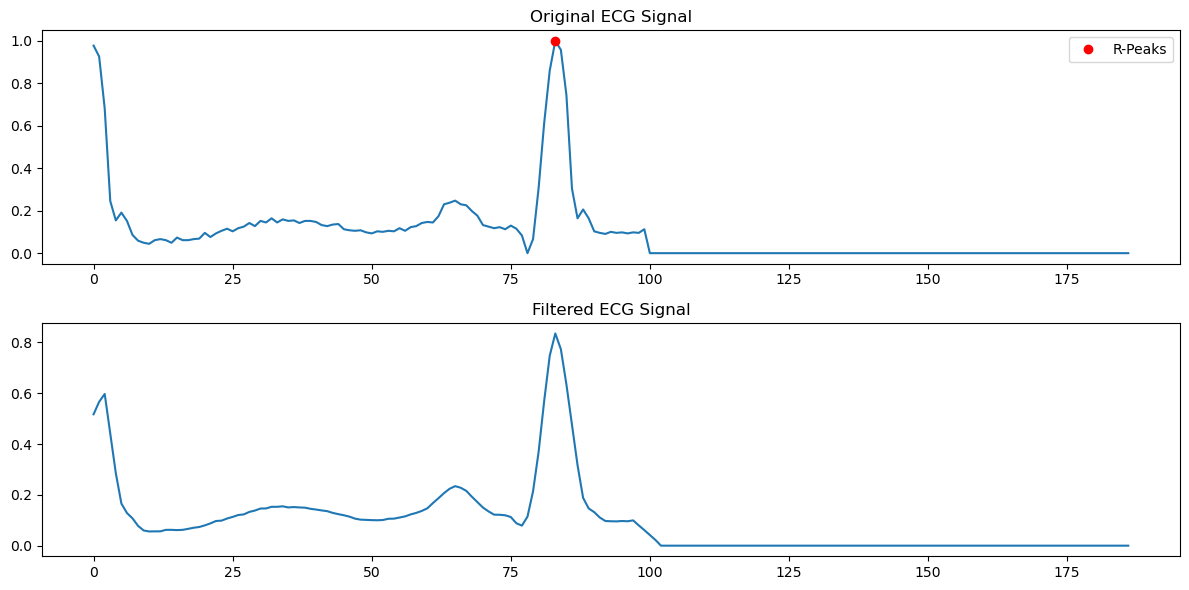


Preprocessing Results for a Sample from Testing Data:


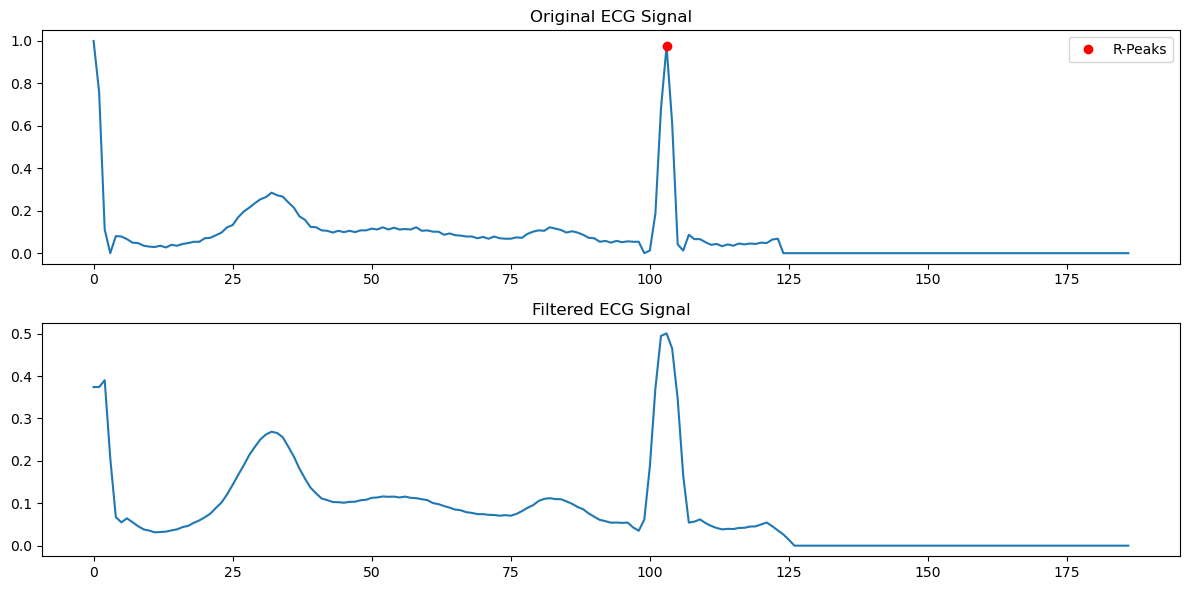

In [3]:
def preprocess_ecg(ecg_data):

    if ecg_data.ndim == 2:
        ecg_data = ecg_data.ravel()
    
    # R-Peak Detection
    rpeak_indices, _ = find_peaks(ecg_data, height=0.6, distance=200)

    window_size = 5
    filtered_ecg = np.convolve(ecg_data, np.ones(window_size)/window_size, mode='same')
    
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(ecg_data)
    plt.plot(rpeak_indices, ecg_data[rpeak_indices], 'ro', label='R-Peaks')
    plt.title("Original ECG Signal")
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.plot(filtered_ecg)
    plt.title("Filtered ECG Signal")
    plt.tight_layout()
    plt.show()

print("Preprocessing Results for a Sample from Training Data:")
preprocess_ecg(X_train[0])  

print("\nPreprocessing Results for a Sample from Testing Data:")
preprocess_ecg(X_test[0]) 

In [4]:
train_dataset = 'mitbih_train.csv'
test_dataset = 'mitbih_test.csv'

train_df = pd.read_csv (train_dataset,header=None)
test_df = pd.read_csv (test_dataset,header=None)
print ('infromation about train data')
train_df.info()
print ('\n infromation about test data')
test_df.info()

infromation about train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB

 infromation about test data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21892 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 31.4 MB


# plot sample from every ECG

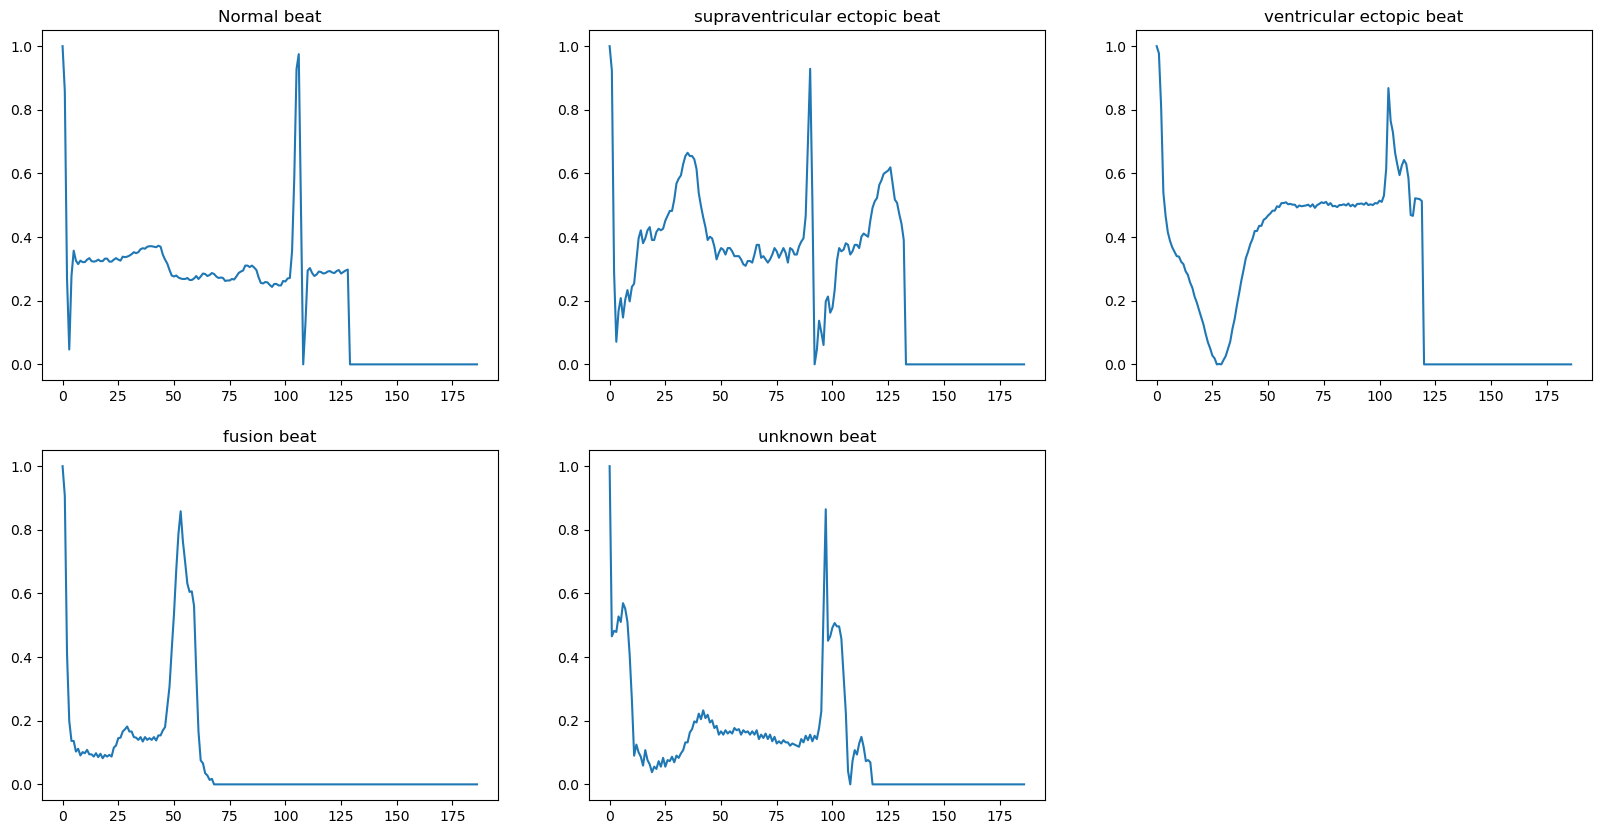

In [5]:
plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
plt.plot (range (0,187), (train_df.loc [train_df[187] ==0]).sample(1).iloc [:,:-1].values[0] )
plt.title ('Normal beat')

plt.subplot(2,3,2)
plt.plot ( (train_df.loc [train_df[187] ==1]).sample(1).iloc [:,:-1].values[0])
plt.title ('supraventricular ectopic beat')

plt.subplot(2,3,3)
plt.plot ( (train_df.loc [train_df[187] ==2]).sample(1).iloc [:,:-1].values[0])
plt.title ('ventricular ectopic beat')

plt.subplot(2,3,4)
plt.plot ( (train_df.loc [train_df[187] ==3]).sample(1).iloc [:,:-1].values[0])
plt.title ('fusion beat')

plt.subplot(2,3,5)
plt.plot ( (train_df.loc [train_df[187] ==4]).sample(1).iloc [:,:-1].values[0])
plt.title ('unknown beat')

plt.show()

# plot number of sample on every heartbeat

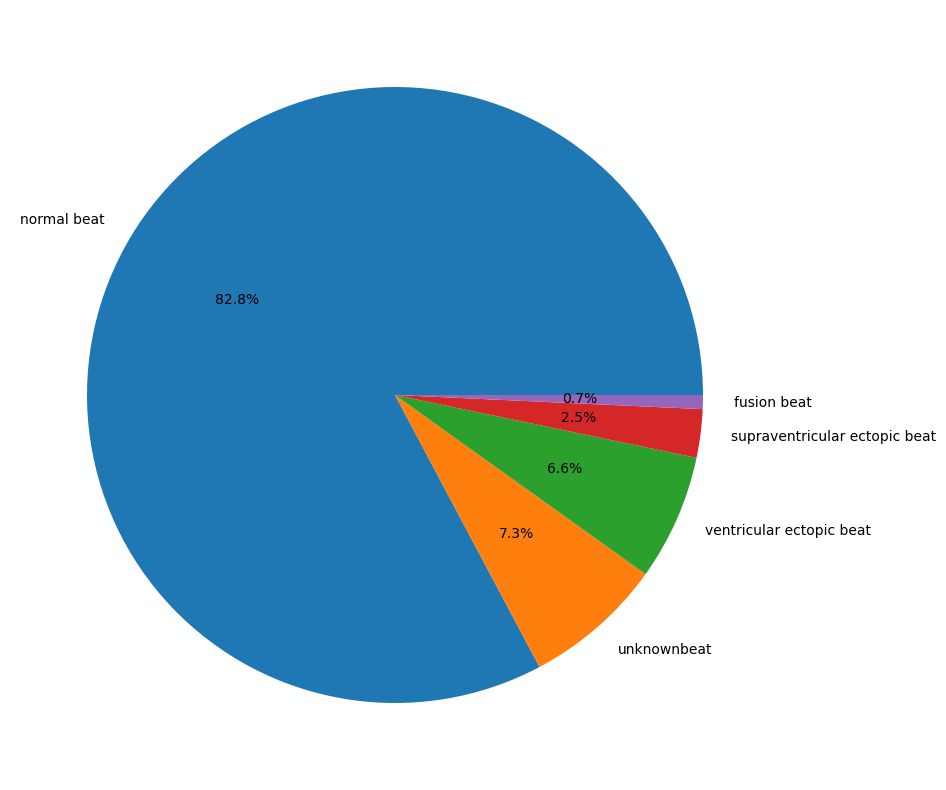

In [6]:
beats = ['normal beat' ,'unknownbeat','ventricular ectopic beat' , 'supraventricular ectopic beat' , 'fusion beat' ]
plt.figure(figsize=(20,10))
plt.pie (train_df [187].value_counts().values,labels = beats,autopct='%1.1f%%')
plt.show()

In [7]:
normal_df = pd.read_csv("ptbdb_normal.csv", header = None)
abnormal_df = pd.read_csv("ptbdb_abnormal.csv", header = None)

In [8]:
normal_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4041,1.000000,0.929586,0.503550,0.293491,0.169822,0.159763,0.130769,0.125444,0.137278,0.111243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4042,1.000000,0.637579,0.154837,0.061983,0.088965,0.083374,0.065143,0.057365,0.060039,0.060039,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4043,1.000000,0.872574,0.465071,0.232212,0.126132,0.155886,0.174644,0.190168,0.203752,0.168823,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4044,0.915983,0.529373,0.288406,0.144536,0.171802,0.180669,0.177566,0.176458,0.178896,0.180448,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
abnormal_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.933970,0.801043,0.749783,0.687229,0.635100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501,0.981409,1.000000,0.559171,0.287093,0.196639,0.204862,0.215946,0.243833,0.242760,0.250268,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10502,0.906250,0.922379,0.878024,0.810484,0.712702,0.667339,0.608871,0.527218,0.480847,0.442540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10503,1.000000,0.867971,0.674122,0.470332,0.296987,0.169307,0.077664,0.081392,0.074868,0.089779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10504,1.000000,0.984672,0.658888,0.556394,0.446809,0.395790,0.315260,0.276367,0.261039,0.258522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [10]:
print(normal_df.shape)
print(abnormal_df.shape)

(4046, 188)
(10506, 188)


In [11]:
# check null value

print(normal_df.isnull().sum())
print(abnormal_df.isnull().sum())

0      0
1      0
2      0
3      0
4      0
      ..
183    0
184    0
185    0
186    0
187    0
Length: 188, dtype: int64
0      0
1      0
2      0
3      0
4      0
      ..
183    0
184    0
185    0
186    0
187    0
Length: 188, dtype: int64


In [12]:
# check the value of each class

print ("\nPTB Normal classes: \n", normal_df[187].value_counts())
print ("\nPTB Abnormal classes: \n", abnormal_df[187].value_counts())


PTB Normal classes: 
 0.0    4046
Name: 187, dtype: int64

PTB Abnormal classes: 
 1.0    10506
Name: 187, dtype: int64


NameError: name 'ptb_type' is not defined

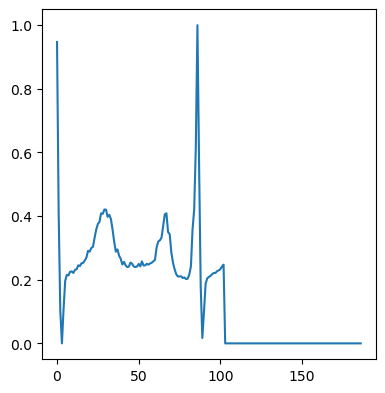

In [15]:
# randomly sampling five data from each class

rnd_normal = np.random.randint(0,normal_df.shape[0],size=(5,))
rnd_abnormal = np.random.randint(0,abnormal_df.shape[0], size=(5,))

# plot the ECG

plt.figure(figsize=(25,10))
np_count = np.linspace(0,186,187)
np_time = np.tile(np_count,(10,1))

for i in range(np_time.shape[0]):
    ax = plt.subplot(2,5,i+1)
    if (i < 5):
        
        # normal beat
        
        ax.plot(normal_df.iloc[rnd_normal[i],np_time[i,:]])
        ax.set_title(ptb_type[normal_df.loc[rnd_normal[i],187]])
    else:
        
        # abnormal beat
        
        ax.plot(abnormal_df.iloc[rnd_abnormal[i-5],np_time[i,:]])
        ax.set_title(ptb_type[abnormal_df.loc[rnd_abnormal[i-5],187]])

plt.show()